In [9]:
import functools
import json
import os
from typing import Any, List, Tuple, Union
import einops
import matplotlib.pyplot as plt
import torch
import torch as t
import torch.nn.functional as F
from fancy_einsum import einsum
from sklearn.linear_model import LinearRegression
from torch import nn
# from toy_transformer import ParenTransformer, SimpleTokenizer
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split

from transformer_lens import utils, ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint
from transformer_lens.components import LayerNorm

from torchtyping import TensorType as TT

plt.rcParams.update({'font.size': 22})

MAIN = __name__ == "__main__"
device = "cuda"
IS_CI = os.getenv("IS_CI")

In [10]:
class SimpleTokenizer:

    START_TOKEN = 0
    PAD_TOKEN = 1
    END_TOKEN = 2
    base_d = {"[start]": START_TOKEN, "[pad]": PAD_TOKEN, "[end]": END_TOKEN}

    def __init__(self, alphabet: str):
        self.alphabet = alphabet
        # the 3 is because there are 3 special tokens (defined just above)
        self.t_to_i = {**{c: i + 3 for i, c in enumerate(alphabet)}, **self.base_d}
        self.i_to_t = {i: c for c, i in self.t_to_i.items()}

    def tokenize(self, strs: List[str], max_len = None) -> TT["batch", "seq"]:
        def c_to_int(c: str) -> int:
            if c in self.t_to_i:
                return self.t_to_i[c]
            else:
                raise ValueError(c)

        if isinstance(strs, str):
            strs = [strs]

        if max_len is None:
            max_len = max((max(len(s) for s in strs), 1))

        ints = [
            [self.START_TOKEN] + [c_to_int(c) for c in s] + [self.END_TOKEN] + [self.PAD_TOKEN] * (max_len - len(s))
            for s in strs
        ]
        return t.tensor(ints)

    def decode(self, tokens) -> List[str]:
        assert tokens.ndim >= 2, "Need to have a batch dimension"
        def int_to_c(c: int) -> str:
            if c < len(self.i_to_t):
                return self.i_to_t[c]
            else:
                raise ValueError(c)

        return [
            "".join(int_to_c(i.item()) for i in seq[1:] if i != self.PAD_TOKEN and i != self.END_TOKEN)
            for seq in tokens
        ]

    def __repr__(self) -> str:
        return f"SimpleTokenizer({self.alphabet!r})"

class BracketsDataset:
    """A dataset containing sequences, is_balanced labels, and tokenized sequences"""

    def __init__(self, data_tuples: list):
        """
        data_tuples is List[Tuple[str, bool]] signifying sequence and label
        """
        self.tokenizer = SimpleTokenizer("()")
        self.strs = [x[0] for x in data_tuples]
        self.isbal = t.tensor([x[1] for x in data_tuples])
        self.toks = self.tokenizer.tokenize(self.strs)
        self.open_proportion = t.tensor([s.count("(") / len(s) for s in self.strs])
        self.starts_open = t.tensor([s[0] == "(" for s in self.strs]).bool()

    def __len__(self) -> int:
        return len(self.strs)

    def __getitem__(self, idx) -> Union["BracketsDataset", Tuple[str, t.Tensor, t.Tensor]]:
        if type(idx) == slice:
            return self.__class__(list(zip(self.strs[idx], self.isbal[idx])))
        return (self.strs[idx], self.isbal[idx], self.toks[idx])

    def to(self, device) -> "BracketsDataset":
        self.isbal = self.isbal.to(device)
        self.toks = self.toks.to(device)
        self.open_proportion = self.open_proportion.to(device)
        self.starts_open = self.starts_open.to(device)
        return self

    @property
    def seq_length(self) -> int:
        return self.toks.size(-1)

    @classmethod
    def with_length(cls, data_tuples: List[Tuple[str, bool]], selected_len: int) -> "BracketsDataset":
        return cls([(s, b) for (s, b) in data_tuples if len(s) == selected_len])

    @classmethod
    def with_start_char(cls, data_tuples: List[Tuple[str, bool]], start_char: str) -> "BracketsDataset":
        return cls([(s, b) for (s, b) in data_tuples if s[0] == start_char])

def LN_hook_names(layernorm: LayerNorm) -> Tuple[str, str]:
    '''
    Returns the names of the hooks immediately before and after a given layernorm.
    e.g. LN_hook_names(model.final_ln) returns ["blocks.2.hook_resid_post", "ln_final.hook_normalized"]
    '''
    if layernorm.name == "ln_final":
        input_hook_name = utils.get_act_name("resid_post", 2)
        output_hook_name = "ln_final.hook_normalized"
    else:
        layer, ln = layernorm.name.split(".")[1:]
        input_hook_name = utils.get_act_name("resid_pre" if ln=="ln1" else "resid_mid", layer)
        output_hook_name = utils.get_act_name('normalized', layer, ln)
    
    return input_hook_name, output_hook_name

VOCAB = "()"

cfg = HookedTransformerConfig(
    n_ctx=42,
    d_model=56,
    d_head=28,
    n_heads=2,
    d_mlp=56,
    n_layers=3,
    attention_dir="bidirectional", # defaults to "causal"
    act_fn="relu",
    d_vocab=len(VOCAB)+3, # plus 3 because of end and pad and start token
    d_vocab_out=2, # 2 because we're doing binary classification
    use_attn_result=True, 
    device="cuda",
    use_hook_tokens=True
)

model = HookedTransformer(cfg).eval()

state_dict = t.load("brackets_model_state_dict.pt") #, map_location="cpu")
model.load_state_dict(state_dict)

tokenizer = SimpleTokenizer("()")

def add_perma_hooks_to_mask_pad_tokens(model: HookedTransformer, pad_token: int) -> HookedTransformer:

    # Hook which operates on the tokens, and stores a mask where tokens equal [pad]
    def cache_padding_tokens_mask(tokens: TT["batch", "seq"], hook: HookPoint) -> None:
        hook.ctx["padding_tokens_mask"] = einops.rearrange(tokens == pad_token, "b sK -> b 1 1 sK")

    # Apply masking, by referencing the mask stored in the `hook_tokens` hook context
    def apply_padding_tokens_mask(
        attn_scores: TT["batch", "head", "seq_Q", "seq_K"],
        hook: HookPoint,
    ) -> None:
        attn_scores.masked_fill_(model.hook_dict["hook_tokens"].ctx["padding_tokens_mask"], -1e5)
        if hook.layer() == model.cfg.n_layers - 1:
            del model.hook_dict["hook_tokens"].ctx["padding_tokens_mask"]

    # Add these hooks as permanent hooks (i.e. they aren't removed after functions like run_with_hooks)
    for name, hook in model.hook_dict.items():
        if name == "hook_tokens":
            hook.add_perma_hook(cache_padding_tokens_mask)
        elif name.endswith("attn_scores"):
            hook.add_perma_hook(apply_padding_tokens_mask)

    return model

model.reset_hooks(including_permanent=True)
model = add_perma_hooks_to_mask_pad_tokens(model, tokenizer.PAD_TOKEN)

N_SAMPLES = 10000
with open("brackets_data.json") as f:
    data_tuples: List[Tuple[str, bool]] = json.load(f)
    print(f"loaded {len(data_tuples)} examples")
assert isinstance(data_tuples, list)
data_tuples = data_tuples[:N_SAMPLES]
data = BracketsDataset(data_tuples).to("cuda")
data_mini = BracketsDataset(data_tuples[:100]).to("cuda")

loaded 100000 examples


In [11]:
paren_emb = np.array([-0.22606339, -0.3817214, -1.4104964, 0.19177942, 1.9899428, 0.4391564, 0.7656387, -0.63001657, 1.2170641, -0.78435856, -2.0772018, 0.5796861, 0.14452729, -1.5480461, -1.4717238, 1.3908799, -2.650712, 2.2939675, 1.9186023, 2.2521715, -0.97538763, -2.0912004, -2.1513553, 1.0542943, -1.6433673, -0.49036485, 1.5739079, -1.6167231, 0.005950656, -0.5535703, -1.6153314, 0.34630018, -1.2608914, 2.3687954, -2.0325658, 2.681696, 1.3179133, 0.21228376, 0.2400737, 2.4026039, -0.22275975, -1.6459382, 0.49807006, 0.4056123, 0.574695, 0.31673485, -1.1493986, 1.0393034, 0.48291945, 1.7879814, 0.32313624, -0.44806415, 1.7664179, 1.3369981, 0.039000615, 0.7465193])

In [12]:
is_left = t.sum(data.toks == 3, dim=1)
is_right = t.sum(data.toks == 4, dim=1)
equal_num = ((is_left - is_right)/(is_left + is_right)).cpu().numpy()

In [13]:
out, cache = model.run_with_cache(data.toks)

In [137]:
# strs = ["(" * i + ")" * (i*2) for i in range(1, 10)]
# strs = ["((()())())()))(())))", "()((()())"]
# strs = [")((())"]
strs = ["()))(" + "(" * (i+1) + ")" * i for i in range(1, 10)]
# strs = ["())" + "(" * (i+1) + ")" * i for i in range(1, 10)]
test_data = tokenizer.tokenize(strs)
results, test_cache = model.run_with_cache(test_data)
results = results[:, 0]
print(results)

tensor([[ 5.7767, -5.9165],
        [ 5.7278, -5.8643],
        [ 5.5289, -5.6792],
        [ 5.3236, -5.4965],
        [ 5.3217, -5.5018],
        [ 5.2945, -5.4799],
        [ 5.3380, -5.5165],
        [ 5.5408, -5.6960],
        [ 5.4463, -5.5929]], device='cuda:0', grad_fn=<SelectBackward0>)


In [65]:
print(cache["blocks.0.mlp.hook_pre"].shape)
print(cache["blocks.0.mlp.hook_post"].shape)
print(cache["blocks.0.hook_mlp_out"].shape)
print(cache)

torch.Size([10000, 42, 56])
torch.Size([10000, 42, 56])
torch.Size([10000, 42, 56])
ActivationCache with keys ['hook_tokens', 'hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.attn.hook_result', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.attn.hook_result', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scal

In [80]:
print(cache["blocks.0.attn.hook_result"].shape)

torch.Size([10000, 42, 2, 56])


In [101]:
data.toks[0]

tensor([0, 3, 3, 4, 3, 3, 3, 4, 4, 3, 4, 3, 3, 3, 3, 4, 4, 3, 4, 4, 4, 3, 3, 2,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

0.4314
0.8106666666666666


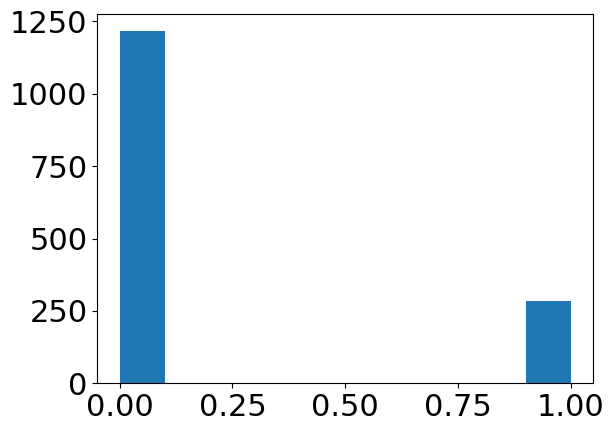

In [107]:
layer = "blocks.0.attn.hook_result"

j = 5

mlp_vectors = cache[layer].cpu().numpy()[:, j, 0]

is_left = t.sum(data.toks[:, j:] == 3, dim=1)
is_right = t.sum(data.toks[:, j:] == 4, dim=1)
mask = (is_left + is_right) >= 6
# equal_num = ((is_left - is_right)/(is_left + is_right)).cpu().numpy()
equal = (is_left == is_right).cpu().numpy()

print(equal.mean())

mlp_vectors_train, mlp_vectors_test, equal_train, equal_test = train_test_split(mlp_vectors[utils.to_numpy(mask)], equal[utils.to_numpy(mask)])

plt.hist(equal_test * 1)

lr = LogisticRegression()
fitted = lr.fit(mlp_vectors_train, equal_train)
print(fitted.score(mlp_vectors_test, equal_test))

In [110]:
layer = "blocks.0.hook_mlp_out"

from sklearn.model_selection import train_test_split
from torch import nn

probe = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(56, 1)
)
probe.to(device)

i = 4

j = 4

mlp_vectors = cache[layer].cpu().numpy()[:, j]

is_left = t.sum(data.toks[:, j:] == 3, dim=1)
is_right = t.sum(data.toks[:, j:] == 4, dim=1)
mask = (is_left + is_right >= 4).cpu().numpy()
# equal_num = ((is_left - is_right)/(is_left + is_right)).cpu().numpy()
equal = (is_left > is_right).cpu().numpy()

# lr = LogisticRegression()

mlp_vectors_train, mlp_vectors_test, equal_train, equal_test = train_test_split(mlp_vectors[mask], equal[mask])
mlp_vectors_train = t.tensor(mlp_vectors_train, requires_grad=False, device=device)
equal_train = t.tensor(equal_train, requires_grad=False, device=device).unsqueeze(1) * 1.
mlp_vectors_test = t.tensor(mlp_vectors_test, requires_grad=False, device=device)
equal_test = t.tensor(equal_test, requires_grad=False, device=device).unsqueeze(1) * 1.

loss = nn.BCEWithLogitsLoss()

opt = t.optim.Adam(probe.parameters(), lr=0.1)
for epoch in range(20000):
    opt.zero_grad()
    preds = probe(mlp_vectors_train)

    l = loss(preds, equal_train)
    l.backward()
    opt.step()

    if epoch % 2000 == 0:
        with t.no_grad():
            preds_test = probe(mlp_vectors_test)
            l_test = loss(preds_test, equal_test)
            print("TRAIN LOSS:", l.item())
            print("TEST LOSS:", l_test.item())

            num_correct_test = t.sum((preds_test > 0) == equal_test)

            print("TEST ACC:", num_correct_test.item() / len(equal_test))

TRAIN LOSS: 0.6534591913223267
TEST LOSS: 0.45923686027526855
TEST ACC: 0.8539257455873402
TRAIN LOSS: 0.18947412073612213
TEST LOSS: 0.1750548630952835
TEST ACC: 0.9403530127814973
TRAIN LOSS: 0.18842750787734985
TEST LOSS: 0.17379705607891083
TEST ACC: 0.938527084601339
TRAIN LOSS: 0.19284547865390778
TEST LOSS: 0.171137735247612
TEST ACC: 0.9440048691418138
TRAIN LOSS: 0.1902516484260559
TEST LOSS: 0.18410781025886536
TEST ACC: 0.9373097991479001
TRAIN LOSS: 0.19125135242938995
TEST LOSS: 0.17568247020244598
TEST ACC: 0.9397443700547778
TRAIN LOSS: 0.19016465544700623
TEST LOSS: 0.16891495883464813
TEST ACC: 0.9427875836883749
TRAIN LOSS: 0.18756017088890076
TEST LOSS: 0.1795312464237213
TEST ACC: 0.938527084601339
TRAIN LOSS: 0.19266873598098755
TEST LOSS: 0.17103438079357147
TEST ACC: 0.9367011564211808
TRAIN LOSS: 0.19263142347335815
TEST LOSS: 0.17396587133407593
TEST ACC: 0.9427875836883749


In [112]:
probe.eval()
preds_test = probe(mlp_vectors_test)
num_correct_test = t.sum((preds_test > 0) == equal_test)
print("TEST ACC:", num_correct_test.item() / len(equal_test))

TEST ACC: 0.9452221545952526


In [128]:
print(np.std(paren_emb))

1.3665234490199314


In [133]:
print(edit_dir)
print(

[-0.22606339 -0.3817214  -1.4104964   0.19177942  1.9899428   0.4391564
  0.7656387  -0.63001657  1.2170641  -0.78435856 -2.0772018   0.5796861
  0.14452729 -1.5480461  -1.4717238   1.3908799  -2.650712    2.2939675
  1.9186023   2.2521715  -0.97538763 -2.0912004  -2.1513553   1.0542943
 -1.6433673  -0.49036485  1.5739079  -1.6167231   0.00595066 -0.5535703
 -1.6153314   0.34630018 -1.2608914   2.3687954  -2.0325658   2.681696
  1.3179133   0.21228376  0.2400737   2.4026039  -0.22275975 -1.6459382
  0.49807006  0.4056123   0.574695    0.31673485 -1.1493986   1.0393034
  0.48291945  1.7879814   0.32313624 -0.44806415  1.7664179   1.3369981
  0.03900062  0.7465193 ]


In [136]:
t.cosine_similarity(t.tensor(probe[1].weight, device="cpu"), t.tensor(paren_emb).unsqueeze(0))

/tmp/ipykernel_110110/3349560394.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t.cosine_similarity(t.tensor(probe[1].weight, device="cpu"), t.tensor(paren_emb).unsqueeze(0))


tensor([-0.0222], dtype=torch.float64)

tensor([[ 1.9917e-01,  8.2956e-02, -2.9577e-03, -1.2205e-01, -2.8438e-01,
          9.4846e-02, -1.5239e-01,  6.8516e-02, -1.2441e-01,  1.5358e-01,
          1.7287e-01,  1.7133e-01,  2.4434e-01, -1.0303e-02, -1.3069e-01,
         -2.0654e-01, -8.4019e-02, -1.9247e-01, -4.8533e-02, -2.9921e-03,
         -4.2827e-02, -9.1634e-03, -1.2175e-01,  1.6028e-01, -1.5322e-01,
         -2.3177e-01,  3.1204e-01, -1.2881e-01, -1.6747e-02, -1.9185e-01,
         -9.8565e-02, -2.1131e-01, -1.1846e-02,  6.3937e-03,  3.0942e-01,
          1.2326e-03,  4.0177e-02, -3.6761e-01, -5.0655e-02, -2.6482e-01,
          2.6936e-01, -1.9283e-01,  2.2083e-01, -2.1826e-01,  2.6462e-01,
         -1.9265e-01,  2.5019e-01,  2.0490e-01,  3.7139e-01, -2.8368e-01,
          1.6010e-01, -2.7979e-01,  4.1073e-02,  1.1378e-01,  1.3101e-01,
         -3.0177e-01],
        [ 2.7317e-01,  1.3089e-01,  8.4175e-02, -1.5677e-01, -3.4464e-01,
          7.2715e-02, -1.6858e-01,  1.0874e-01, -1.7650e-01,  1.8029e-01,
          2.849

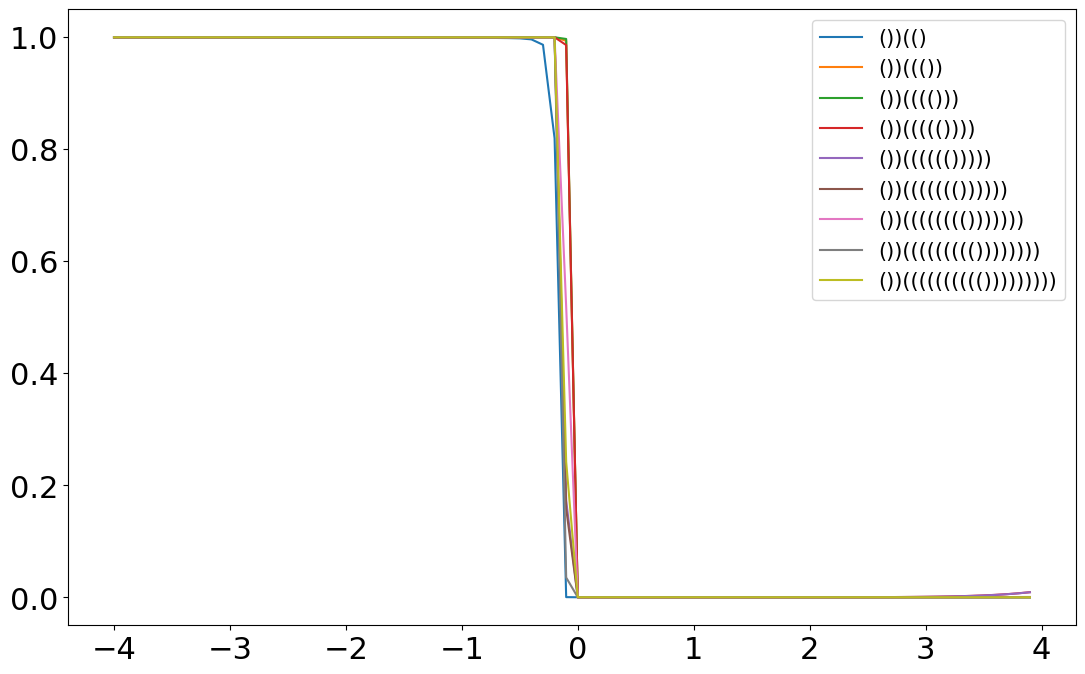

In [130]:
edit_dir = probe[1].weight
# edit_dir = paren_emb

from functools import partial

model.reset_hooks()

def intervene(value, hook, intervention):
    # value[:, 0] += intervention0
    value[:, 4] += intervention
    # output[:, 1] += intervention

    return value

low = -4
high = 4
scalings = np.arange(low, high, 0.1)

preds = []

for i in scalings:

    # preds.append([])

    # for j in scalings:

    intervention = t.tensor(edit_dir * i, device=device)
    interv_func = partial(intervene, intervention=intervention)
    out = model.run_with_hooks(test_data, fwd_hooks=[
        ("blocks.0.hook_attn_out", interv_func)
    ])

    pred_valid = t.softmax(out[:, 0], dim=-1)[:, 1]
    preds.append(pred_valid.detach().cpu().numpy())

preds = np.array(preds)

plt.figure(figsize=(13, 8))
preds = np.array(preds)
objs = plt.plot(scalings, preds)
plt.legend(objs, strs, fontsize=15)

In [113]:
new_mlp_out = t.tensor(test_cache["blocks.0.hook_mlp_out"][:, 4], requires_grad=True, device=device)

loss = nn.BCEWithLogitsLoss()
opt = t.optim.Adam([new_mlp_out], lr=0.1)

for i in range(10):
    opt.zero_grad()
    output = probe(new_mlp_out)
    l = loss(output, t.zeros(len(output), 1, device=device))
    print(l.item())

    l.backward()
    opt.step()

1.4108364582061768
0.03521910682320595
0.0014337190659716725
0.00011828728020191193
1.533812792331446e-05
2.7285639134788653e-06
6.225371862456086e-07
1.721911786489727e-07
5.2981903309046174e-08
0.0


/tmp/ipykernel_110110/4033946840.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_mlp_out = t.tensor(test_cache["blocks.0.hook_mlp_out"][:, 4], requires_grad=True, device=device)


In [138]:
from functools import partial

model.reset_hooks()

def intervene(value, hook, intervention0, intervention1):
    
    # value[:, 0] += intervention0
    value[:, 5] += intervention0
    value[:, 6] += intervention1
    # output[:, 1] += intervention

    return value

low = -0.5
high = 0.05
scalings = np.arange(low, high, 0.01)

preds = []

for i in scalings:

    preds.append([])

    for j in scalings:

        intervention0 = t.tensor(paren_emb * i, device=device)
        intervention1 = t.tensor(paren_emb * j, device=device)
        interv_func = partial(intervene, intervention0=intervention0, intervention1=intervention1)
        out = model.run_with_hooks(test_data, fwd_hooks=[
            ("blocks.0.hook_attn_out", interv_func)
        ])

        pred_valid = t.softmax(out[:, 0], dim=-1)[:, 1]
        preds[-1].append(pred_valid.detach().cpu().numpy())

preds = np.array(preds)

# plt.figure(figsize=(13, 8))
# preds = np.array(preds)
# objs = plt.plot(scalings, preds)
# plt.legend(objs, strs, fontsize=15)

# plt.xlabel("Intervention Amount on Token #4")

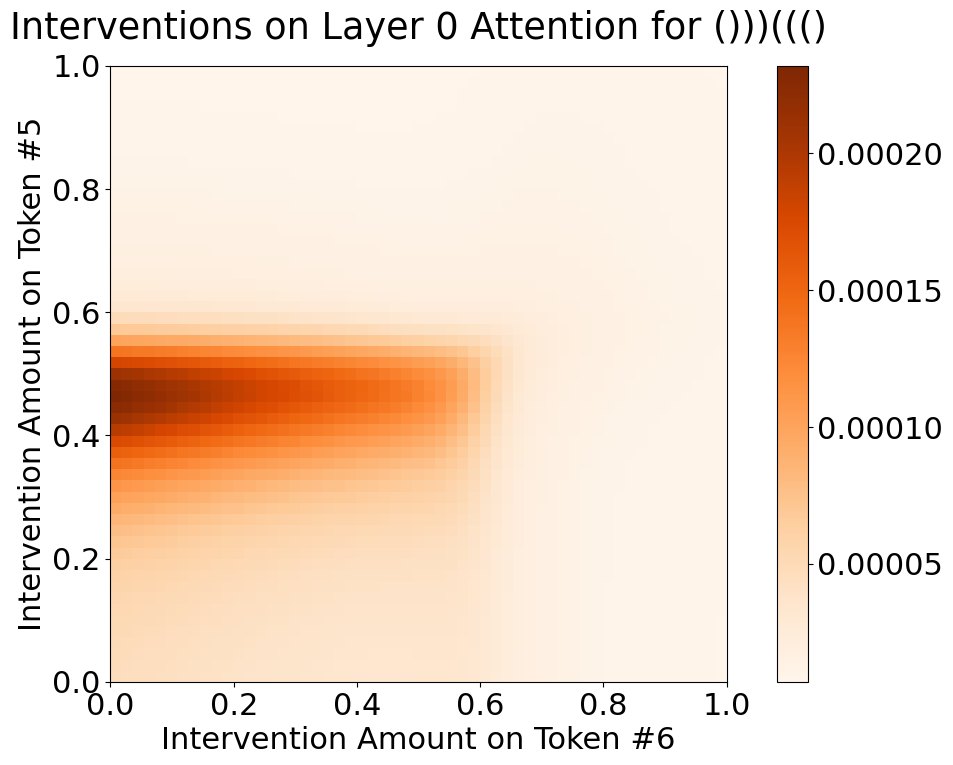

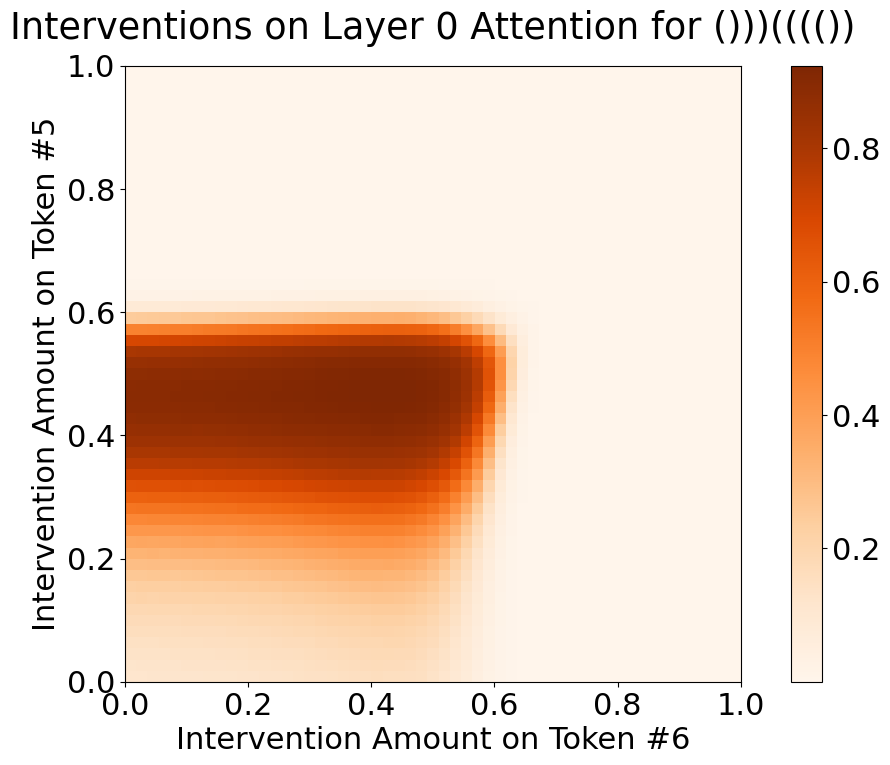

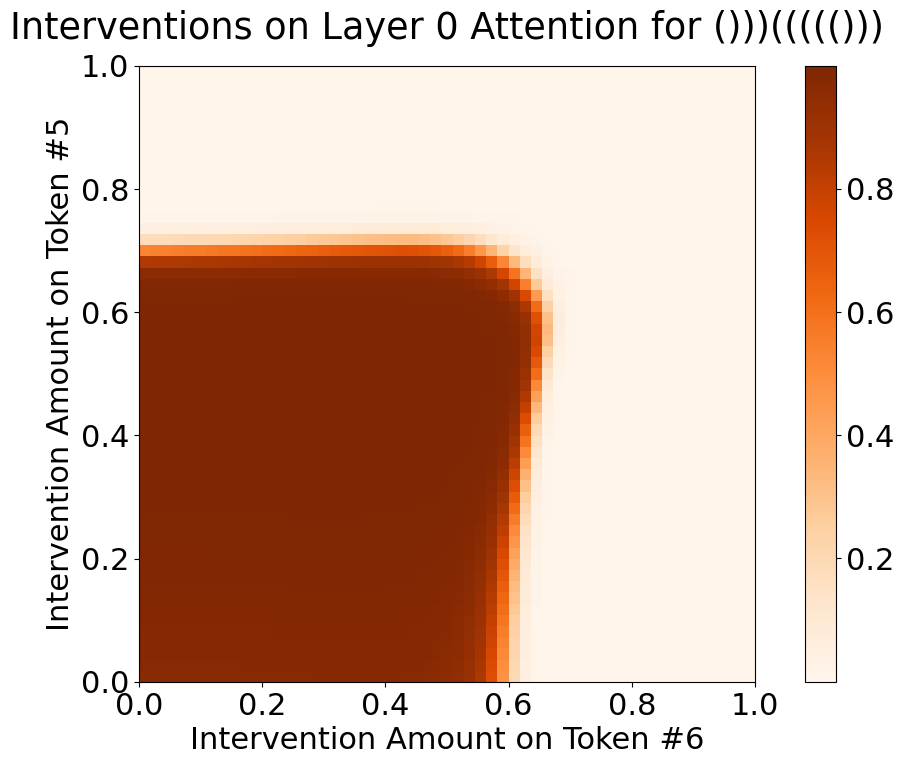

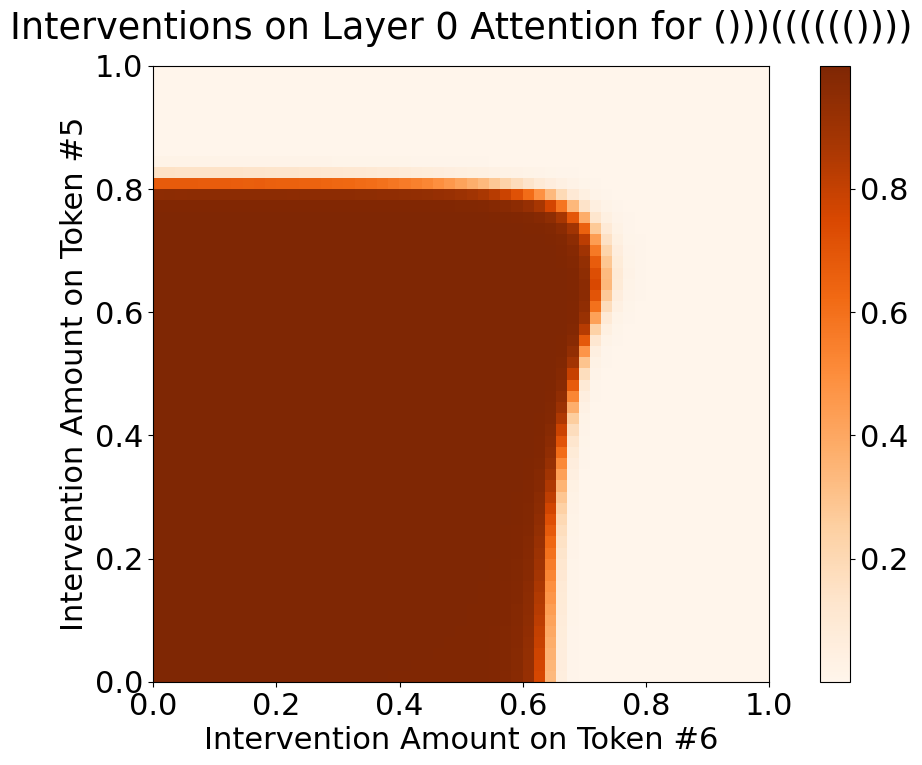

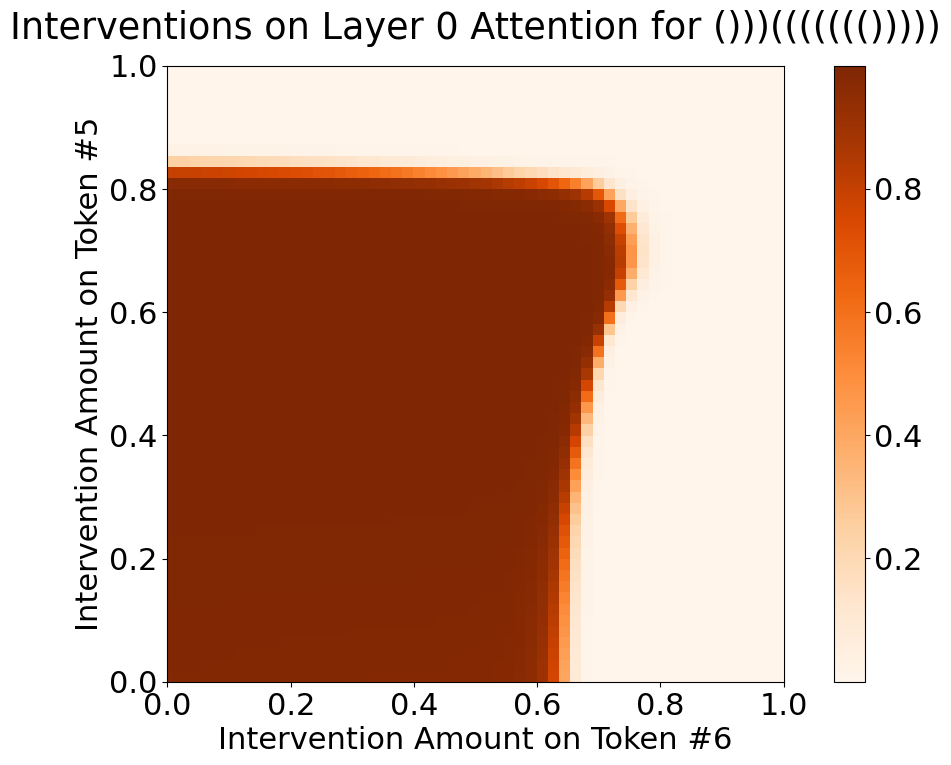

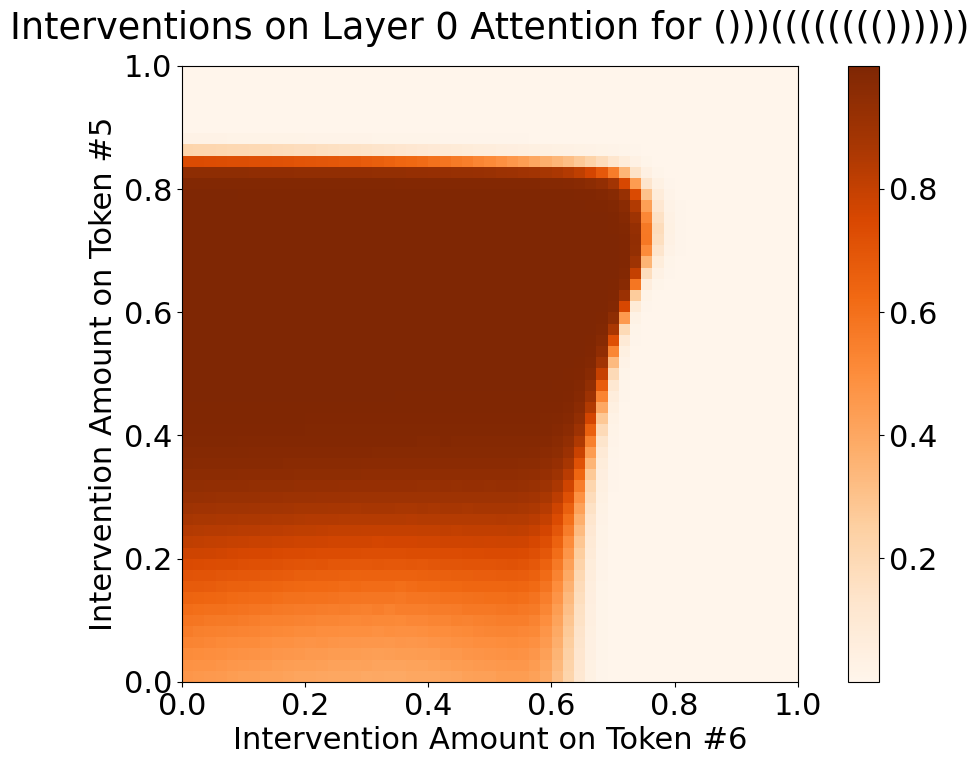

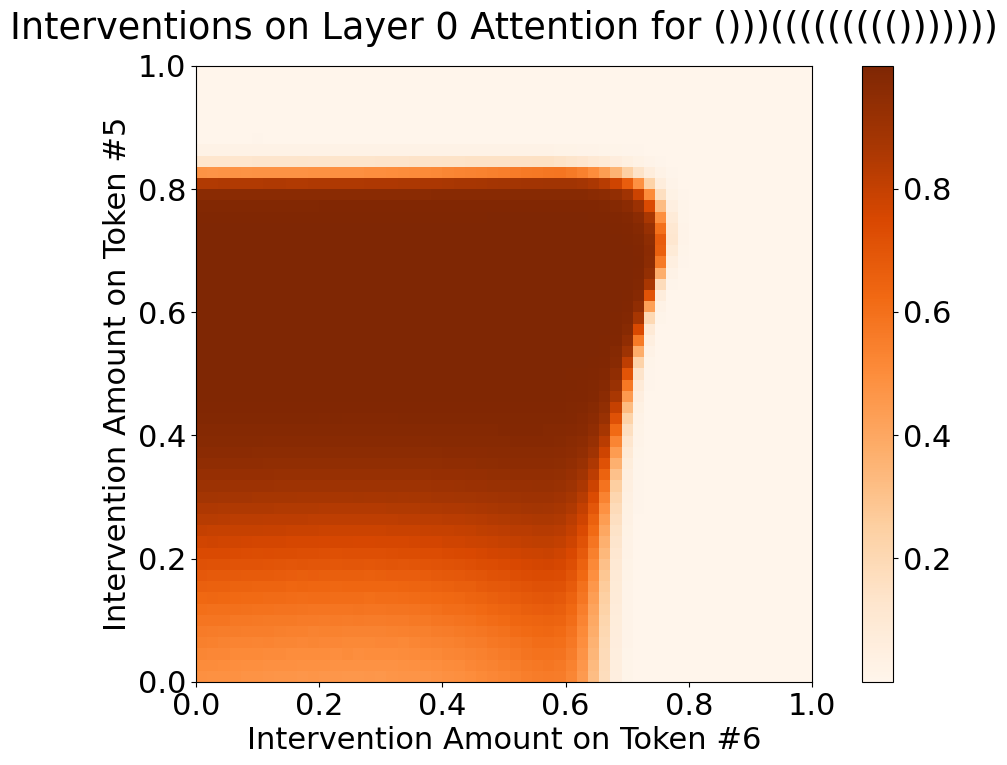

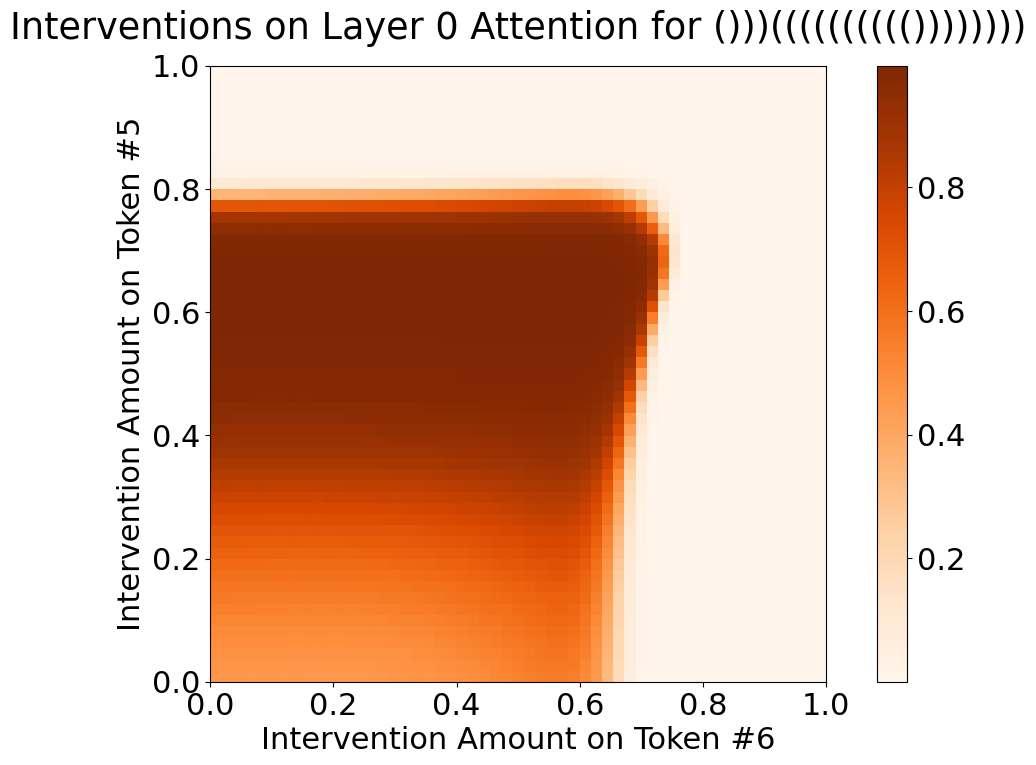

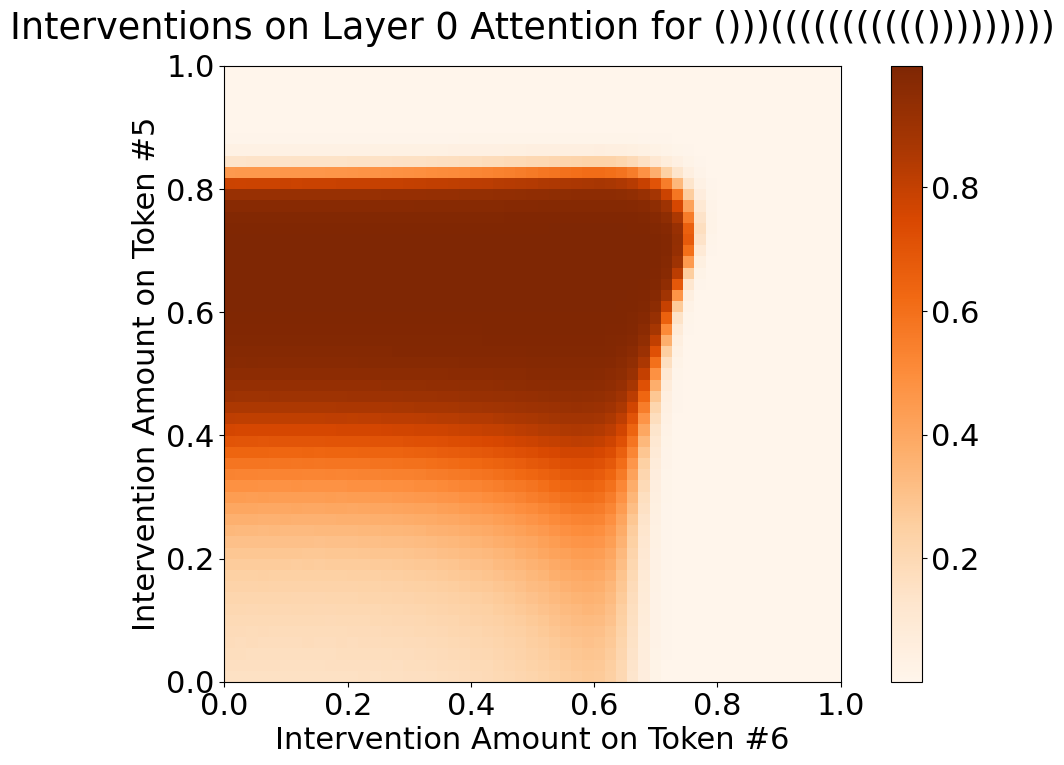

In [71]:
for index in range(len(strs)):
    plt.figure(figsize=(13, 8))
    plt.imshow(preds[:, :, index], cmap="Oranges", extent=[low, high, low, high], origin='lower')
    plt.colorbar()
    plt.ylabel("Intervention Amount on Token #5")
    plt.xlabel("Intervention Amount on Token #6")
    plt.title(f"Interventions on Layer 0 Attention for {strs[index]}", y=1.03)

In [36]:
linear = Ridge(alpha=10000)
linear_scores = np.zeros((24, 24))
# for i in range(24):
i = 4
    
token_vector = cache["blocks.0.hook_attn_out"][:, i].cpu().numpy()

j = 4

# for j in range(2, 24):

#     if abs(i - j) >= 4:
#         continue

is_left = t.sum(data.toks[:, j:] == 3, dim=1)
is_right = t.sum(data.toks[:, j:] == 4, dim=1)
equal_num = ((is_left - is_right)/(is_left + is_right)).cpu().numpy()

token_vector = token_vector[~np.isnan(equal_num)]
equal_num = equal_num[~np.isnan(equal_num)]

linear = Ridge(alpha=10000000)

fitted_linear = linear.fit(token_vector, equal_num)
linear_scores[i][j] = fitted_linear.score(token_vector, equal_num)
print(i, j)
print(linear_scores[i][j])

# print()
print(t.cosine_similarity(t.tensor(paren_emb).unsqueeze(0), t.tensor(linear.coef_)))
    # linear_coefs[layer][head][token] = fitted_linear.coef_

# logistic = LogisticRegression()
# fitted_logistic = logistic.fit(head_train, equal_num_train > 0)
# logistic_scores_more0[layer][head][token] = fitted_logistic.score(head_test, equal_num_test > 0)

# logistic = LogisticRegression()
# fitted_logistic = logistic.fit(head_train, equal_num_train < 0)
# logistic_scores_less0[layer][head][token] = fitted_logistic.score(head_test, equal_num_test < 0)

4 4
0.005128084250442644
tensor([0.9882], dtype=torch.float64)


In [226]:
# INTERVENING ON NET UNBALANCED SEQUENCES
from functools import partial

model.reset_hooks()

def intervene(value, hook, intervention0, intervention1):
    
    value[:, 0] += intervention0
    value[:, 1] += intervention1
    # output[:, 1] += intervention

    return value

scalings = np.arange(0, 1, 0.1)

preds = []

for i in scalings:

    preds.append([])

    for j in scalings:

        intervention0 = t.tensor(paren_emb * i, device=device)
        intervention1 = t.tensor(paren_emb * j, device=device)
        interv_func = partial(intervene, intervention0=intervention0, intervention1=intervention1)
        out = model.run_with_hooks(test_data, fwd_hooks=[
            ("blocks.0.hook_attn_out", interv_func)
        ])

        pred_valid = t.softmax(out[:, 0], dim=-1)[:, 1]
        preds[-1].append(pred_valid.detach().cpu().numpy())

preds = np.array(preds)

Text(0.5, 1.03, 'Interventions on Layer 0 Output of Heads')

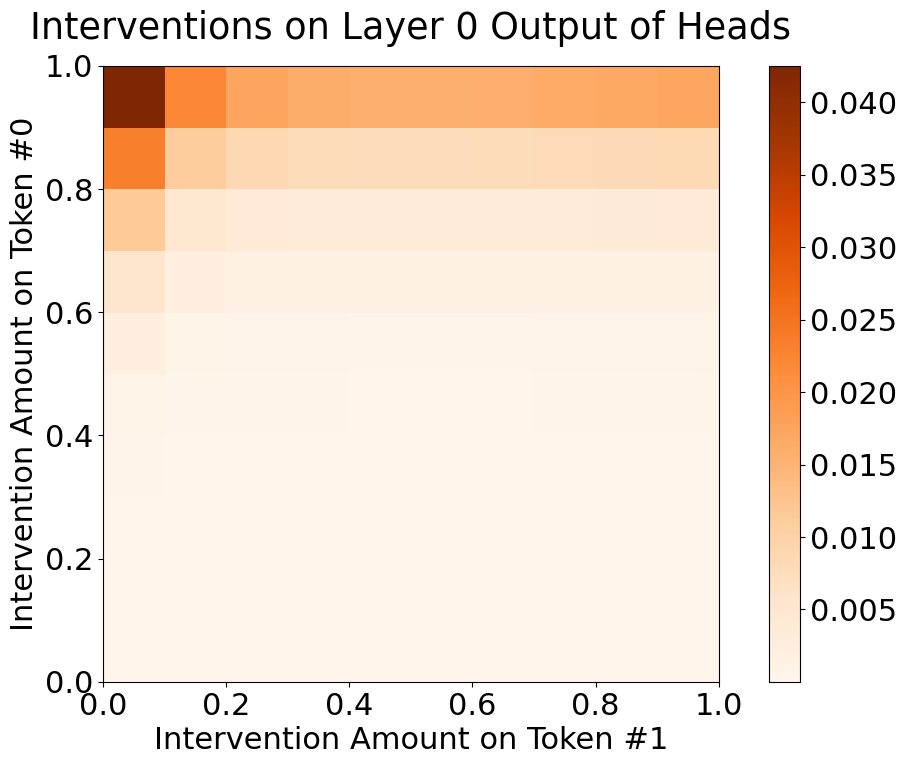

In [231]:
plt.figure(figsize=(13, 8))
plt.imshow(preds[:, :, 1], cmap="Oranges", extent=[0, 1, 0, 1], origin='lower')
plt.colorbar()
plt.ylabel("Intervention Amount on Token #0")
plt.xlabel("Intervention Amount on Token #1")
plt.title("Interventions on Layer 0 Output of Heads", y=1.03)

In [ ]:

plt.plot(scalings, t.log(preds[:, 1]))

Text(0.5, 1.0, 'Intervention scores w/ scaling on Token #0 = 0.3')

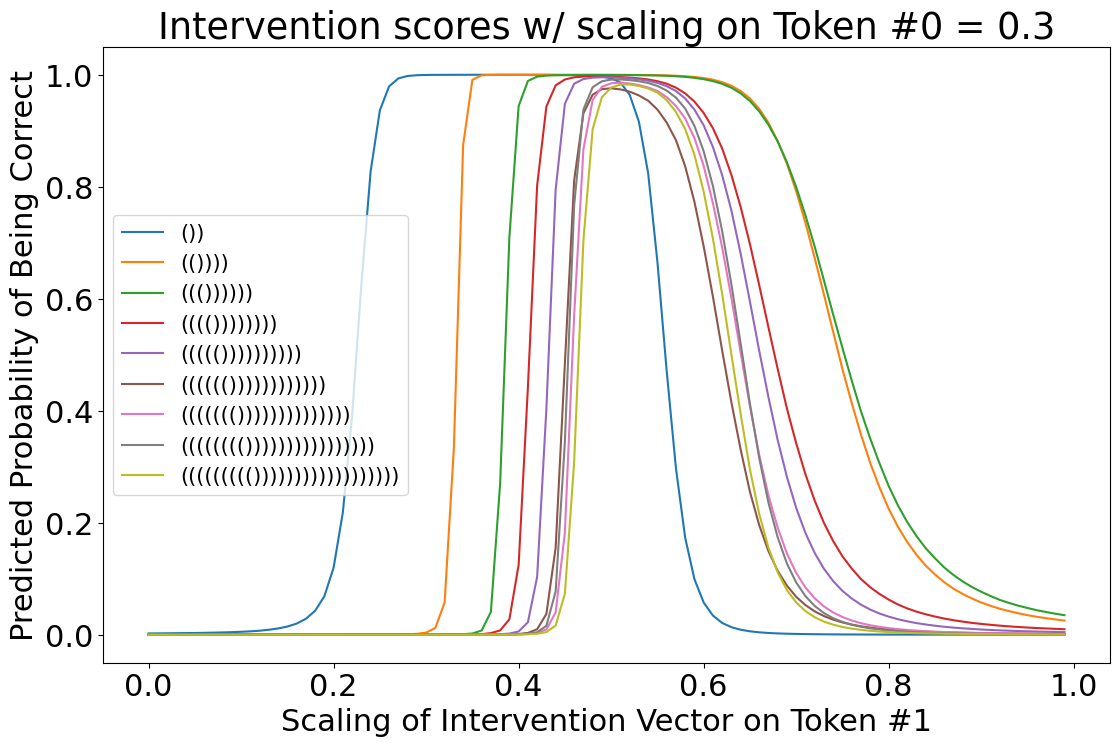

In [217]:
i = 30
plt.figure(figsize=(13, 8))
objs = plt.plot(scalings, preds[i])
plt.legend(objs, strs, fontsize=15)
plt.xlabel("Scaling of Intervention Vector on Token #1")
plt.ylabel("Predicted Probability of Being Correct")
plt.title(f"Intervention scores w/ scaling on Token #0 = 0.3")

0.9654630603489766
0.02685552225185399


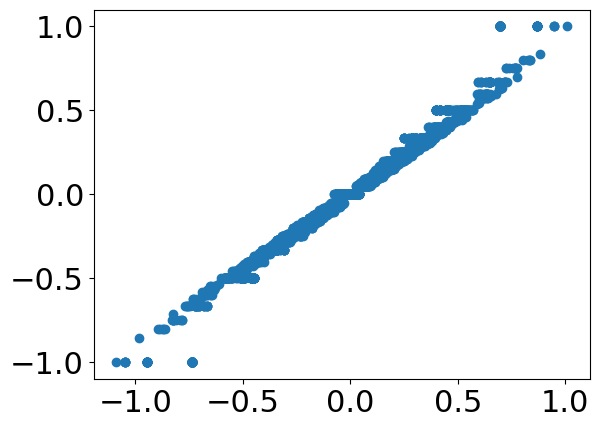

In [112]:
linear = Ridge(alpha=0.1)
fitted_linear = linear.fit(cache["blocks.0.hook_attn_out"][:, 0].cpu(), equal_num)

print(linear.score(cache["blocks.0.hook_attn_out"][:, 0].cpu(), equal_num))
# fitted_linear = linear.fit(cache["blocks.0.attn.hook_result"][:, 0, 0].cpu(), equal_num)

plt.scatter(linear.predict(cache["blocks.0.hook_attn_out"][:, 0].cpu()), equal_num)

print(t.cosine_similarity(t.tensor(fitted_linear.coef_), t.tensor(paren_emb).unsqueeze(0)).item())

In [83]:
out_sample, cache_sample = model.run_with_cache(tokenizer.tokenize(["(((((((((((())))))))))))))))))))))))", ")()()"]))

print(linear.predict(cache_sample["blocks.0.hook_attn_out"][:, 0].cpu()))

print(out_sample[:, 0])

[-0.17107461 -0.06421768]
tensor([[ 4.7736, -4.9026],
        [ 5.0956, -5.1525]], device='cuda:0', grad_fn=<SelectBackward0>)


In [13]:
linear_scores = np.zeros((3, 2, 2))
linear_coefs = np.zeros((3, 2, 2, 56))
# logistic_scores_less0 = np.zeros((3, 2, 2))
# logistic_scores_more0 = np.zeros((3, 2, 2))

with t.inference_mode():
    
    for layer in range(3):

        head_all = cac

        for head in range(2):

            for token in range(2):

                head_train, head_test, equal_num_train, equal_num_test = train_test_split(head_all[:, head, token], equal_num, test_size=0.1)

                linear = Ridge(alpha=10000)
                fitted_linear = linear.fit(head_train, equal_num_train)
                linear_scores[layer][head][token] = fitted_linear.score(head_test, equal_num_test)
                linear_coefs[layer][head][token] = fitted_linear.coef_

                # logistic = LogisticRegression()
                # fitted_logistic = logistic.fit(head_train, equal_num_train > 0)
                # logistic_scores_more0[layer][head][token] = fitted_logistic.score(head_test, equal_num_test > 0)

                # logistic = LogisticRegression()
                # fitted_logistic = logistic.fit(head_train, equal_num_train < 0)
                # logistic_scores_less0[layer][head][token] = fitted_logistic.score(head_test, equal_num_test < 0)

In [22]:
model(tokenizer.tokenize(["(((()))))", "))"]).to(device))

tensor([[-9.5124e-05, -9.2607e+00],
        [-1.2111e-04, -9.0188e+00]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [6]:
with t.inference_mode():
    head_all = get_out_by_head(model, data, 0).cpu().numpy()

head = head_all[:, 0, 1]

In [93]:
print(equal_num.shape)
print(head.shape)

(100000,)
(100000, 56)


In [97]:
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split

head_train, head_test, equal_num_train, equal_num_test = train_test_split(head, equal_num, test_size=0.1)

linear = Ridge(alpha=0.1)
fitted_linear = linear.fit(head_train, equal_num_train)
print("LINEAR TRAIN SCORE: ", fitted_linear.score(head_train, equal_num_train))
print("LINEAR TEST SCORE: ", fitted_linear.score(head_test, equal_num_test))

logistic = LogisticRegression()
fitted_logistic = logistic.fit(head, equal_num > 0)
print("LOGISTIC TRAIN SCORE: ", fitted_logistic.score(head_train, equal_num_train > 0))
print("LOGISTIC TEST SCORE: ", fitted_logistic.score(head_test, equal_num_test > 0))

LINEAR TRAIN SCORE:  0.9433968252058565
LINEAR TEST SCORE:  0.9446982943055677
LOGISTIC TRAIN SCORE:  0.9493777777777778
LOGISTIC TEST SCORE:  0.9514


/home/ubuntu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [1]:
import numpy as np

index = 0

is_left = t.sum(data.toks[index:] == 3, dim=1)
is_right = t.sum(data.toks[index:] == 4, dim=1)
equal_num = ((is_left - is_right)/(is_left + is_right)).cpu().numpy()

paren_emb = np.array([-0.22606339, -0.3817214, -1.4104964, 0.19177942, 1.9899428, 0.4391564, 0.7656387, -0.63001657, 1.2170641, -0.78435856, -2.0772018, 0.5796861, 0.14452729, -1.5480461, -1.4717238, 1.3908799, -2.650712, 2.2939675, 1.9186023, 2.2521715, -0.97538763, -2.0912004, -2.1513553, 1.0542943, -1.6433673, -0.49036485, 1.5739079, -1.6167231, 0.005950656, -0.5535703, -1.6153314, 0.34630018, -1.2608914, 2.3687954, -2.0325658, 2.681696, 1.3179133, 0.21228376, 0.2400737, 2.4026039, -0.22275975, -1.6459382, 0.49807006, 0.4056123, 0.574695, 0.31673485, -1.1493986, 1.0393034, 0.48291945, 1.7879814, 0.32313624, -0.44806415, 1.7664179, 1.3369981, 0.039000615, 0.7465193])
dot_scores = np.dot(head_all[:, 0, index], paren_emb[:, None])[:, 0]
plt.scatter(dot_scores, equal_num)

NameError: name 't' is not defined

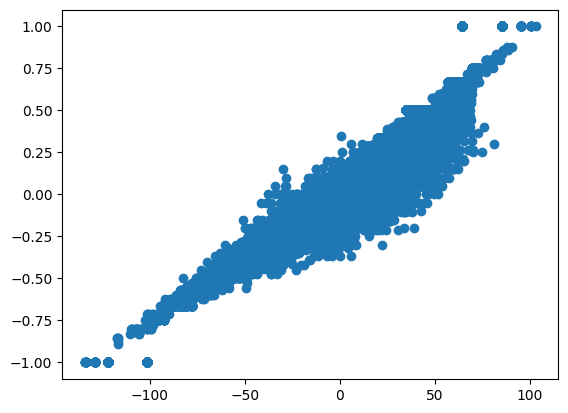

In [108]:
import numpy as np

paren_emb = np.array([-0.22606339, -0.3817214, -1.4104964, 0.19177942, 1.9899428, 0.4391564, 0.7656387, -0.63001657, 1.2170641, -0.78435856, -2.0772018, 0.5796861, 0.14452729, -1.5480461, -1.4717238, 1.3908799, -2.650712, 2.2939675, 1.9186023, 2.2521715, -0.97538763, -2.0912004, -2.1513553, 1.0542943, -1.6433673, -0.49036485, 1.5739079, -1.6167231, 0.005950656, -0.5535703, -1.6153314, 0.34630018, -1.2608914, 2.3687954, -2.0325658, 2.681696, 1.3179133, 0.21228376, 0.2400737, 2.4026039, -0.22275975, -1.6459382, 0.49807006, 0.4056123, 0.574695, 0.31673485, -1.1493986, 1.0393034, 0.48291945, 1.7879814, 0.32313624, -0.44806415, 1.7664179, 1.3369981, 0.039000615, 0.7465193])
dot_scores = np.dot(head, paren_emb[:, None])[:, 0]
plt.scatter(dot_scores, equal_num)

In [99]:
print(list(fitted_linear.coef_))
print(fitted_linear.intercept_)

[0.6957917, 0.59944093, -1.0147251, 3.8021724, -3.5778842, 1.6739573, -0.29665315, 0.6043825, -0.7319515, 0.72144914, -1.5906075, -0.7782403, 0.43377784, 0.93158233, -2.5924559, -0.962626, -1.0297241, 0.13413242, -0.8444396, 0.31689143, 0.9103052, -0.52191836, -1.4871575, -0.26765567, 2.1903932, 0.354667, 1.0537567, -1.5249196, 1.5180318, -0.12691274, -0.35784832, 1.7299594, -0.5756264, -3.8590117, -0.53154993, -0.025224507, 0.9939769, -0.8150835, -1.1005669, -0.5077586, -0.16486959, -0.42760968, -1.444979, 0.33551675, -1.440161, 0.67834026, 0.20499009, 0.83807296, 1.8270139, -1.2330928, 0.9159838, -0.1344012, 2.529079, 0.8573505, 0.4836902, -0.32683372]
-1.4240535


In [91]:
print(fitted_linear.coef_)
print(fitted_linear.intercept_)

[ 203.89867    -85.39272    198.81613    -70.11029   -185.94077
 -371.7755     241.11273   -116.778885    89.805435     8.642548
  -99.72683    113.35329    325.12143   -234.48303     38.77481
  348.44952    336.28815    -79.82727   -342.4427      51.81051
 -216.90881   -372.40344   -202.81696    338.92065    -16.24034
  159.88925    -91.38898     22.917664   138.89667   -163.70291
   68.135056   304.10608    132.2829    -106.853935   -31.945587
 -109.22226    -27.928917   -20.00038     61.088947  -171.24222
 -146.82693    -21.021461   297.66013   -264.2655    -250.93457
  411.97977     63.968277   146.41164    -39.349426   141.69286
   -3.2745552 -106.78399    118.69666   -255.423      -81.99983
  201.02673  ]
3.4669752


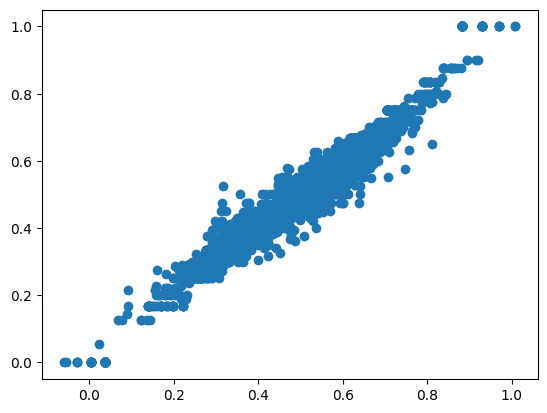

In [88]:
plt.scatter(fitted_linear.predict(head_test), equal_num_test)

In [59]:
fitted_lr.predict(head.cpu())

array([ 2.906311  ,  1.7578735 , -0.5648804 , ..., -2.9223022 ,
        1.4907837 , -0.49017334], dtype=float32)

In [31]:
cache = None

def cache_fn(module, input, out):
    global cache
    cache = out.detach()

hooks = []
# for i, layer in enumerate(model.layers):
#     if i == 0
hooks.append(model.layers[0].self_attn.register_forward_hook(cache_fn))

with t.inference_mode():
    model(data.toks)

for hook in hooks:
    hook.remove()

In [34]:
print(model.layers[0])

TransformerBlock(
  (norm1): LayerNorm((56,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((56,), eps=1e-05, elementwise_affine=True)
  (self_attn): BertSelfAttention(
    (project_query): Linear(in_features=56, out_features=56, bias=True)
    (project_key): Linear(in_features=56, out_features=56, bias=True)
    (project_value): Linear(in_features=56, out_features=56, bias=True)
    (project_output): Linear(in_features=56, out_features=56, bias=True)
  )
  (linear1): Linear(in_features=56, out_features=56, bias=True)
  (linear2): Linear(in_features=56, out_features=56, bias=True)
  (activation): ReLU()
)


In [33]:
print(cache.shape)

torch.Size([100000, 42, 56])


In [25]:
for hook in hooks:
    hook.remove()